# RNA Inference

Michael Fatemi, February 2023

Here, we will use the cell detections from the `Cell_Detection` notebook (after ensuring that they are non-maximum suppressed) to infer RNA expression for patch images. You must have a set of genes ready, I'm using `filtered_set.npy`, which is the 1000 most spatially-variable genes according to SpatialDE on the original Visium slides.

In [1]:
import torchvision
import torch
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import torchvision.transforms as T

from datasets import Slide, PatchDatasetWithCellAnnotations

def standard_scaler(patch_or_patches: torch.Tensor):
    # patch.shape: ([B,] 3, H, W)
    # ([B,] 3, 1, 1)
    mean = patch_or_patches.mean(dim=(-2, -1), keepdim=True)
    std = patch_or_patches.std(dim=(-2, -1), keepdim=True)
    return (patch_or_patches - mean) / std

genes_to_use = list(np.load("filtered_set.npy"))
slide = Slide.load("input_data/preprocessed/autostainer_40x_cropped.pkl")
slide = slide.select_genes(genes_to_use).binary()

PIL.Image.MAX_IMAGE_PIXELS = 1e10

inferences = torch.load("cell-detections/autostainer_orig/combined_nms.pt")

dataset = PatchDatasetWithCellAnnotations(slide, inferences, 512, 1, device=torch.device('cuda'), patch_transform=standard_scaler)

feature_count = len(slide.genes)

print("Number of genes:", feature_count)

Number of genes: 975


In [2]:
import torch.nn.functional as F

# Rotates a point 90 degrees K times
def rotate90(x, y, k):
    if k == 0:
        return x, y
    return rotate90(-y, x, k - 1)

# Rotates a point 90 degrees K times around a specified origin point
def rotate90_around(x, y, cx, cy, k):
    x2, y2 = rotate90(x - cx, y - cy, k)
    return x2 + cx, y2 + cy

def cells_model_forward_with_mean_aggregation(model, image, boxes, apply_rotations=False, box_size=64, return_cell_level_predictions=False):
    # get cell locations
    cell_locations = [
        (((box[0] + box[2]) / 2).item() * 2, ((box[1] + box[3]) / 2).item() * 2)
        for box in boxes
    ]
    rad = box_size // 2
    if apply_rotations:
        k = torch.randint(low=0, high=3, size=()).item()
        image = torch.rot90(image, k, dims=[-2, -1])
        cell_locations = [
            rotate90_around(cx, cy, 256, 256, k)
            for cx, cy in cell_locations
        ]
    # filter cell locations and save the indexes that are part of the result
    cell_indexes = [
        i
        for i in range(len(cell_locations))
        if 512 - rad > cell_locations[i][0] > rad and 512 - rad > cell_locations[i][1] > rad
    ]
    cell_locations = [
        (cx, cy)
        for cx, cy in cell_locations
        if 512 - rad > cx > rad and 512 - rad > cy > rad
    ]
    cell_images = [
        image[:, int(cy) - rad:int(cy) + rad, int(cx) - rad:int(cx) + rad]
        for cx, cy in cell_locations
    ]
#     if return_cell_image_tensors:
#         for x in cell_images:
#             x.requires_grad_()
    if len(cell_images) == 0:
        return None
    cell_image_embeddings = model(torch.stack(cell_images))
#     # distances: softmax(-r^2)
#     distances = torch.tensor([((2-cx/64)**2 + (2-cy/64)**2) for cx, cy in cell_locations], device='cuda')
#     distances = distances - distances.min()
#     distances = torch.softmax(distances, dim=0)
#     distances[distances < 1e-8] = 0
    # Instead of using distances, just use mean
#     cell_image_embeddings = cell_image_embeddings.T @ distances
#     results = cell_image_embeddings.T @ distances # .mean(dim=0)
    if return_cell_level_predictions:
#         return cell_image_embeddings.mean(dim=0), cell_images, cell_indexes
        return cell_image_embeddings, cell_indexes
    else:
        return cell_image_embeddings.mean(dim=0)
#     return results

Create the training and validation sets

In [3]:
import tqdm

torch.manual_seed(0)

quadrant_masks = slide.get_quadrant_masks()
valid_mask = quadrant_masks[0]

# Creates a `slide` with the given quadrant
quadrants = slide.create_quadrants()

annotations = inferences

valid_annotations = [annotations[i] for i in range(len(annotations)) if valid_mask[i]]
train_annotations = [annotations[i] for i in range(len(annotations)) if not valid_mask[i]]

valid_quadrant, train_quadrant = quadrants[0]
valid_ds = PatchDatasetWithCellAnnotations(valid_quadrant, valid_annotations, 512, 1, device=torch.device('cuda'), patch_transform=standard_scaler)
train_ds = PatchDatasetWithCellAnnotations(train_quadrant, train_annotations, 512, 1, device=torch.device('cuda'), patch_transform=standard_scaler)

The choice of loss function is very important. I found that using regular binary crossentropy loss resulted in poor generalization, while reweighting positive and negative samples within the same batch to have the same importance in the loss function resulted in much higher performance on the validation set.

In [12]:
# To consider in the future: Focal loss and margin loss

import torchvision.ops

def focal_loss(logits, labels):
    # https://pytorch.org/vision/main/_modules/torchvision/ops/focal_loss.html
    return torchvision.ops.focal_loss.sigmoid_focal_loss(logits, labels, alpha=-1, reduction='mean')

def balanced_bce(logits, labels):
    pos = labels == 1
    neg = ~pos
    pos_logits = logits[pos]
    neg_logits = logits[neg]
    pos_labels = labels[pos]
    neg_labels = labels[neg]

    return 0.5 * (F.binary_cross_entropy_with_logits(pos_logits, pos_labels) + F.binary_cross_entropy_with_logits(neg_logits, neg_labels))

## Training the baseline model

In [13]:
import torchvision.transforms as T

def get_fresh_baseline_model():
    global feature_count
    
    baseline_model = torchvision.models.inception_v3('IMAGENET1K_V1').cuda()
    baseline_model.aux_logits = False
    baseline_model.fc = torch.nn.Linear(in_features=2048, out_features=feature_count, bias=True).cuda()
    
    return baseline_model
    

def train_baseline_model(num_epochs, loss_fn, batch_size, checkpoint_model=None):
    global feature_count
    
    # Baseline model
    if checkpoint_model is not None:
        baseline_model = checkpoint_model.cuda()
    else:
        baseline_model = get_fresh_baseline_model().cuda()

    baseline_model_optim = torch.optim.Adam(baseline_model.parameters())
    baseline_model.train()

    for epoch in range(num_epochs):
        with tqdm.tqdm(total=len(train_ds), desc='Training...') as pbar:
            i = 0
            running_loss = 0
            running_loss_baseline = 0
            dataloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=PatchDatasetWithCellAnnotations.collate_fn)
            transform = T.Compose([
                T.ColorJitter(),
                T.RandomRotation(90),
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip()
            ])
            for images, labels, boxes in dataloader:
                images = transform(images)
                preds = baseline_model(images)
                baseline_model_optim.zero_grad()
                loss = loss_fn(preds, labels.float())
                loss.backward()
                baseline_model_optim.step()

                running_loss += loss.item() * len(images)
                i += len(images)

                pbar.update(len(images))
                pbar.set_postfix(loss=loss.item(), running_loss=running_loss/i)
    
    return baseline_model

In [72]:
TRAIN_BASELINE_MODEL = False
if TRAIN_BASELINE_MODEL:
#     baseline_model = train_baseline_model(num_epochs=2, loss_fn=focal_loss, batch_size=32, checkpoint_model=None)
#     torch.save(baseline_model.state_dict(), "baseline_model_inceptionv3_1_focal.pt")
    
    baseline_model = train_baseline_model(num_epochs=2, loss_fn=balanced_bce, batch_size=32, checkpoint_model=None)
    torch.save(baseline_model.state_dict(), "baseline_model_inceptionv3_1_balanced_bce.pt")
else:
    baseline_model_focal = get_fresh_baseline_model()
    baseline_model_focal.load_state_dict(torch.load("baseline_model_inceptionv3_1_focal.pt"))
    
    baseline_model_balanced_bce = get_fresh_baseline_model()
    baseline_model_balanced_bce.load_state_dict(torch.load("baseline_model_inceptionv3_1_balanced_bce.pt"))

/dartfs-hpc/rc/home/x/f006jnx/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


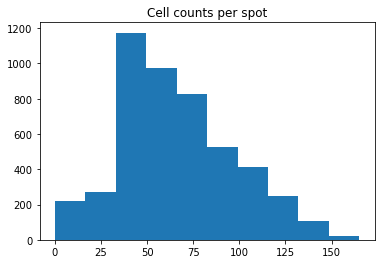

Total cell detections: 313640
Mean cells per spot: 65.6425282544998


In [16]:
# number of cells detected per square
cell_counts = [len(inference['boxes']) for inference in annotations]
plt.title("Cell counts per spot")
plt.hist(cell_counts)
plt.show()
print("Total cell detections:", sum(cell_counts))
print("Mean cells per spot:", sum(cell_counts) / len(annotations))

## Training the cells-based model

This uses the same `forward()` method from above, just aggregating gene expression for cells using the distance from the origin with softmax and embedding each cell with a CNN. Should use graph attention architecture to improve performance, though.

Here, we set up the model for training, and assign spots to the held-out quadrant (`in_quadrant`) and the training data (`out_quadrant`).

In [17]:
def get_fresh_cells_model():
    # https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights
    model = torchvision.models.resnet50('IMAGENET1K_V1')
    # Use a custom FC layer
    model.fc = torch.nn.Linear(in_features=2048, out_features=feature_count, bias=True).cuda()
    return model.cuda()

def get_first_quadrant_indexes(slide):
    # New model
    in_quadrant = []
    out_quadrant = []

    mid_x = slide.spot_locations.image_x.median()
    mid_y = slide.spot_locations.image_y.median()

    for i in range(len(slide.spot_locations)):
        if slide.spot_locations.image_x[i] <= mid_x and slide.spot_locations.image_y[i] <= mid_y:
            in_quadrant.append(i)
        else:
            out_quadrant.append(i)
            
    return in_quadrant, out_quadrant

This cell is used to train the model. Here, it says that I ran for two epochs, but I was continuing a run from earlier that I believed had been under-fit.

In [82]:
def train_cells_model(num_epochs, batch_size, loss_fn, slide, sample_indexes, checkpoint_model=None):
    if checkpoint_model is not None:
        model = checkpoint_model
    else:
        model = get_fresh_cells_model()
    model.train()
    # Train the FC and the rest of the model jointly
    optim = torch.optim.Adam(model.parameters(), lr=1e-5)

    torch.manual_seed(0)
    # This is the order that training samples will be sampled by
    train_perm = torch.randperm(len(sample_indexes))

    train_transforms = T.Compose([
        T.ColorJitter(),
    ])
    
    for epoch in range(num_epochs):
        with tqdm.tqdm(total=len(train_perm), desc='Training epoch ' + str(epoch)) as pbar:
            i = 0
            running_loss = 0
            while i < len(train_perm):
                # `out_quadrant` is an array where each item is an index in the original slide.
                # This is how spots are assigned to training or testing data: We record which indexes are
                # in each split
                idxs = [sample_indexes[train_perm[j]] for j in range(i, min(i + batch_size, len(train_perm)))]
                optim.zero_grad()
                # Store the predictions and labels for this batch. We run each instance of the batch individually,
                # because the `forward()` function deals with variable numbers of cells. However, we take the loss
                # function across all predictions, to ensure smoother training.
                preds = []
                labels = []
                for idx in idxs:
                    image, label, boxes = dataset[idx]
                    # Just color jitter right now. Rotations are applied in the forward() method
                    # because it's easier to transform the boxes and the image at the same time.
                    image = train_transforms(image)
                    result = cells_model_forward_with_mean_aggregation(
                        model,
                        image,
                        inferences[idx]['boxes'],
                        apply_rotations=True)

                    # Check to see if there were enough cells to make the prediction. If there were,
                    # store the result and use it in the loss function.
                    if result is not None:
                        preds.append(result)
                        labels.append(label.float())

                # Backpropagation
                loss = loss_fn(torch.stack(preds), torch.stack(labels))
                loss.backward()
                optim.step()

                # Log some metrics, make a nice progress bar
                N = len(preds)
                running_loss += loss.item() * N
                i += N
                pbar.update(N)
                pbar.set_postfix(loss=loss.item(), running_loss=running_loss/i)
                
    return model

In [107]:
TRAIN_CELLS_MODEL = True
in_quadrant, out_quadrant = get_first_quadrant_indexes(slide)
if TRAIN_CELLS_MODEL:
    cells_model_ep5 = train_cells_model(
        num_epochs=5,
        batch_size=32,
        loss_fn=balanced_bce,
        slide=slide,
        sample_indexes=out_quadrant,
        checkpoint_model=None,
    )
    # Save the resulting model
    torch.save(cells_model_ep5.state_dict(), "cell_model_resnet50_1_epoch5_balanced_bce.pt")
else:
    cells_model = get_fresh_cells_model()
    cells_model.load_state_dict(torch.load("cell_model_resnet50_1_epoch5_focal.pt"))

/dartfs-hpc/rc/home/x/f006jnx/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Training epoch 4: 100%|██████████| 3626/3626 [03:16<00:00, 18.45it/s, loss=0.506, running_loss=0.534]


### Validation

Now that we have our model, I wrote a validation function so we can check out the distribution of accuracy, true|false positive|negatives, precision, recall, and AUROC. I store the AUROC for later as well.

In [35]:
def validate(pred_logits, spot_counts, save_to_dir=None):
    import matplotlib.pyplot as plt
    
    pred_logits = pred_logits.cpu()

    # tp = pred_tensor_bool == dataset.labels
    true_bool = spot_counts.bool()
    pred_scores = torch.sigmoid(pred_logits)
    pred_bool = pred_logits > 0

    # These are Boolean masks indicating each sample as TP, TN, FP, FN
    # Similar variables with trailing underscores indicate aggregate rates
    # for that gene across all samples.
    tp = true_bool & pred_bool
    tn = ~(true_bool | pred_bool)
    fp = ~true_bool & pred_bool
    fn = true_bool & ~pred_bool

    acc = true_bool == pred_bool

    accuracy = acc.sum(axis=0) / true_bool.shape[0]
    plt.title("Histogram of accuracy")
    plt.hist(accuracy)
    if save_to_dir:
        plt.savefig(save_to_dir + "/accuracy.png")
    else:
        plt.show()

    tp_ = tp.sum(axis=0) / true_bool.shape[0]
    plt.title("Histogram of TP")
    plt.hist(tp_)
    plt.xlim(0, 1)
    if save_to_dir:
        plt.savefig(save_to_dir + "/tp.png")
    else:
        plt.show()

    tn_ = tn.sum(axis=0) / true_bool.shape[0]
    plt.title("Histogram of TN")
    plt.hist(tn_)
    plt.xlim(0, 1)
    if save_to_dir:
        plt.savefig(save_to_dir + "/tn.png")
    else:
        plt.show()

    fp_ = fp.sum(axis=0) / true_bool.shape[0]
    plt.title("Histogram of FP")
    plt.hist(fp_)
    plt.xlim(0, 1)
    if save_to_dir:
        plt.savefig(save_to_dir + "/fp.png")
    else:
        plt.show()

    fn_ = fn.sum(axis=0) / true_bool.shape[0]
    plt.title("Histogram of FN")
    plt.xlim(0, 1)
    plt.hist(fn_)
    if save_to_dir:
        plt.savefig(save_to_dir + "/fn.png")
    else:
        plt.show()

    precision = tp.sum(axis=0) / (tp.sum(axis=0) + fp.sum(axis=0))
    plt.title("Histogram of Precision")
    plt.xlim(0, 1)
    plt.hist(precision)
    if save_to_dir:
        plt.savefig(save_to_dir + "/precision.png")
    else:
        plt.show()

    recall = tp.sum(axis=0) / (tp.sum(axis=0) + fn.sum(axis=0))
    plt.title("Histogram of Recall")
    plt.xlim(0, 1)
    plt.hist(recall)
    if save_to_dir:
        plt.savefig(save_to_dir + "/recall.png")
    else:
        plt.show()
    
    import sklearn.metrics
    
    auroc = sklearn.metrics.roc_auc_score(true_bool.numpy(), pred_scores.numpy(), average=None)
    plt.title("Histogram of AUROC")
    plt.xlim(0, 1)
    plt.hist(auroc)
    if save_to_dir:
        plt.savefig("hists/auroc.png")
    else:
        plt.show()

    print("Median precision:", precision.nanmedian())
    print("Median recall:", recall.median())
    print("Median AUROC:", np.nanmedian(auroc))
    
    return {
        "accuracy": accuracy,
        "tp": tp_,
        "tn": tn_,
        "fp": fp_,
        "fn": fn_,
        "precision": precision,
        "recall": recall,
        "auroc": auroc,
    }

### Validation Loop

This is very similar to the training loop, but we swap the `out_quadrant` split with the `in_quadrant` split, and use `torch.no_grad()`. Predictions are added to an aggregate list, and we do not shuffle the order of validation predictions so we can verify their accuracy.

In [99]:
import gc

gc.collect(), torch.cuda.empty_cache()

(0, None)

In [67]:
def validate_baseline_model(model, loss_fn, batch_size, dataset):
    predictions = []
    
    model.train()

    with tqdm.tqdm(total=len(dataset), desc='Training...') as pbar:
        i = 0
        running_loss = 0
        running_loss_baseline = 0
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=PatchDatasetWithCellAnnotations.collate_fn)
        for images, labels, boxes in dataloader:
            with torch.no_grad():
                preds = baseline_model(images)
                loss = loss_fn(preds, labels.float())

            running_loss += loss.item() * len(images)
            i += len(images)

            pbar.update(len(images))
            pbar.set_postfix(loss=loss.item(), running_loss=running_loss/i)

            predictions.extend(preds)
            
    stats = validate(torch.stack(predictions), dataset.slide.spot_counts)
    
    return {"stats": stats, "predictions": predictions}

Training...: 100%|██████████| 1231/1231 [00:11<00:00, 105.39it/s, loss=0.111, running_loss=0.16] 


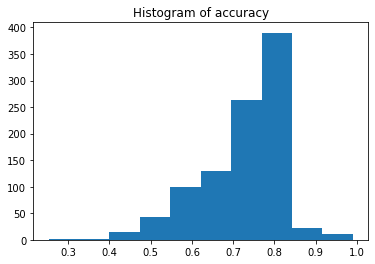

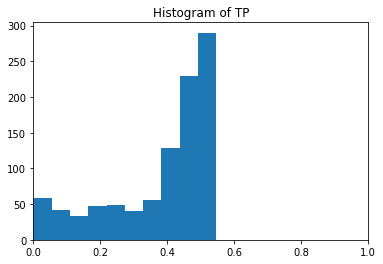

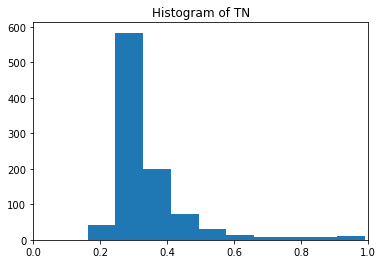

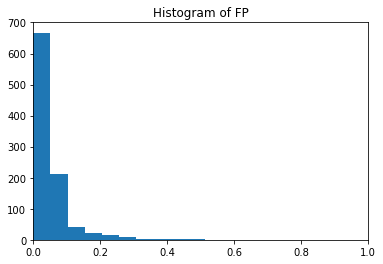

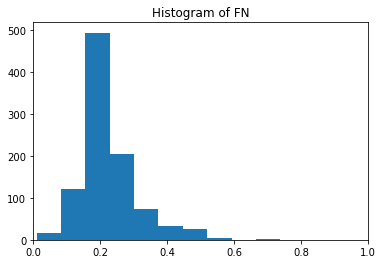

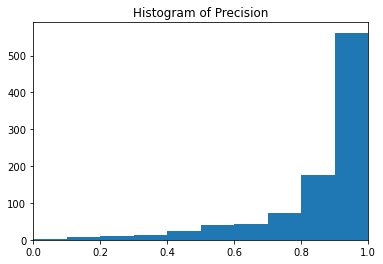

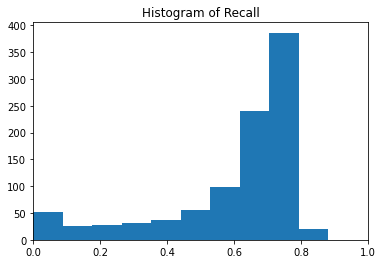

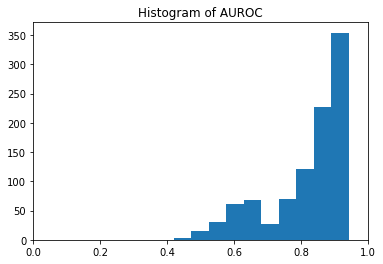

Median precision: tensor(0.9217)
Median recall: tensor(0.6833)
Median AUROC: 0.8641000534092932


In [71]:
baseline_model_validation_results_focal = validate_baseline_model(baseline_model_focal, loss_fn=focal_loss, batch_size=32, dataset=valid_ds)

Training...: 100%|██████████| 1231/1231 [00:11<00:00, 104.54it/s, loss=0.499, running_loss=0.553]


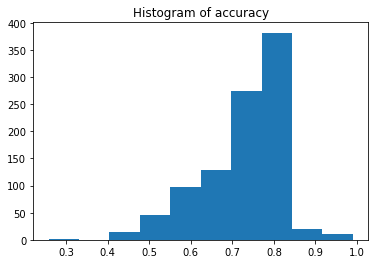

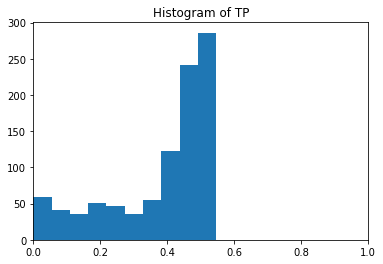

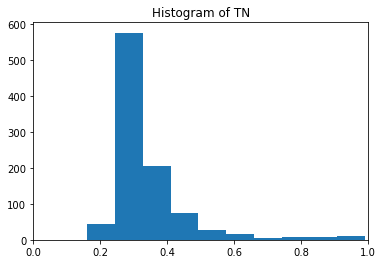

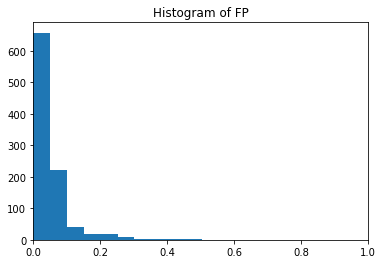

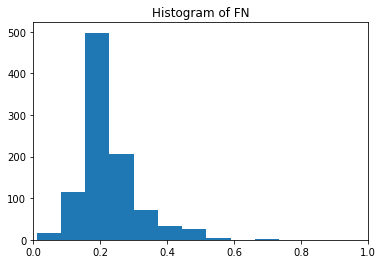

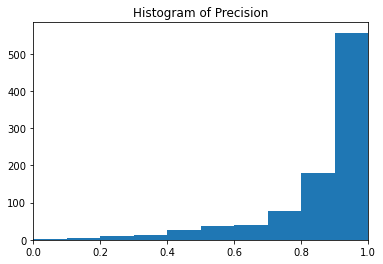

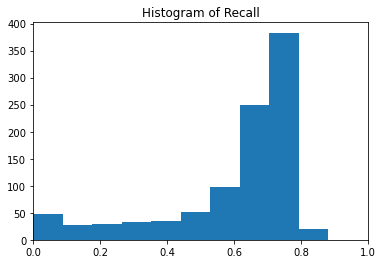

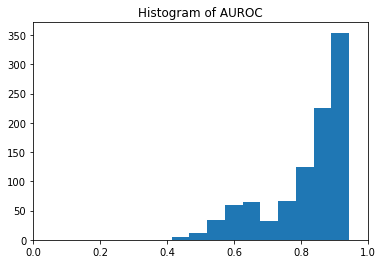

Median precision: tensor(0.9217)
Median recall: tensor(0.6817)
Median AUROC: 0.8642714331892681


In [74]:
baseline_model_validation_results_balanced_bce = validate_baseline_model(baseline_model_balanced_bce, loss_fn=balanced_bce, batch_size=32, dataset=valid_ds)

In [84]:
def validate_cells_model(model, loss_fn, batch_size, dataset, sample_indexes):
    predictions = []

    model.train()

    with tqdm.tqdm(total=len(sample_indexes), desc='Validating...') as pbar:
        i = 0
        running_loss = 0
        while i < len(sample_indexes):
            idxs = [sample_indexes[j] for j in range(i, min(i + batch_size, len(sample_indexes)))]
            # Experiment: Find attribution of each cell
            with torch.no_grad():
                preds = []
                labels = []
                cells = []
                for idx in idxs:
                    image, label, boxes = dataset[idx]
                    # cell based model
                    preds_ = cells_model_forward_with_mean_aggregation(model, image, inferences[idx]['boxes'])
                    preds.append(preds_)
                    labels.append(label.float())

                predictions.extend(preds)
                loss = loss_fn(torch.stack(preds), torch.stack(labels))
                running_loss += loss.item() * len(idxs)

            i += len(idxs)
            pbar.update(len(idxs))
            pbar.set_postfix(loss=loss.item(), running_loss=running_loss/i)
            
    stats = validate(torch.stack(predictions), slide.spot_counts[in_quadrant])
    
    return {"stats": stats, "predictions": predictions}

Validating...: 100%|██████████| 1152/1152 [00:25<00:00, 44.36it/s, loss=0.203, running_loss=0.157]


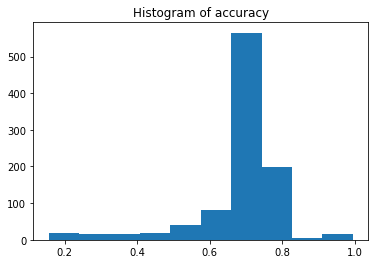

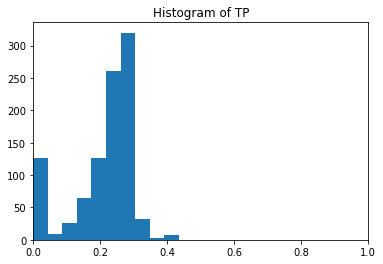

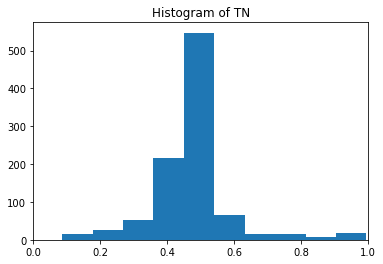

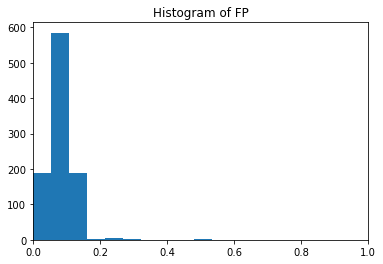

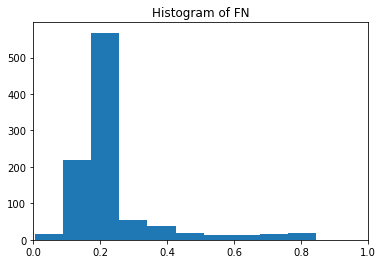

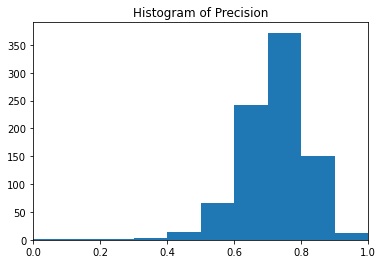

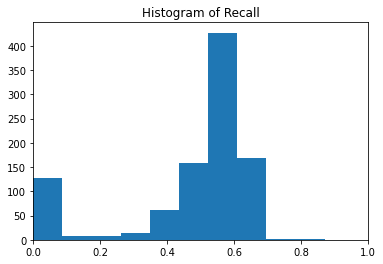

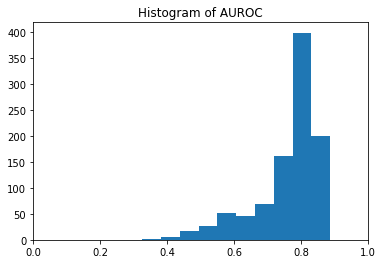

Median precision: tensor(0.7299)
Median recall: tensor(0.5519)
Median AUROC: 0.7936720589352169


In [100]:
cell_model_validation_results = validate_cells_model(cells_model, batch_size=32, loss_fn=focal_loss, dataset=dataset, sample_indexes=in_quadrant)

## Get Attributions for Each Cell

This runs the model on the validation set and returns the predictions on a cell-by-cell level. In traditional training, we take the mean of these and make the loss function run over the aggregate prediction. However, hopefully we have learned a decent understanding of the cell-level gene expression in the process!

We can test with several genes to see if they highlight cells that are more likely to be correlated. For example, when testing with EPCAM, we hope to see that epithelial cells are highlighted.

Our function returns the cell-level predictions, as well as the indexes of the cells used (for that patch) for that prediction. This is because cells may be filtered out if they go off the edge of the slide, depending on the size of the box we crop the cell into.

In [101]:
# Visualize attributions
def get_attributions(model, batch_size):
    model.train()

    attributions = []

    with tqdm.tqdm(total=len(in_quadrant), desc='Validating...') as pbar:
        i = 0
        running_loss = 0
        while i < len(in_quadrant):
            idxs = [in_quadrant[j] for j in range(i, min(i + batch_size, len(in_quadrant)))]
            preds = []
            labels = []
            cells = []
            with torch.no_grad():
                for idx in idxs:
                    image, label, boxes = dataset[idx]
                    # cell based model
                    preds_, cell_indexes_ = cells_model_forward_with_mean_aggregation(model, image, inferences[idx]['boxes'], return_cell_level_predictions=True)
                    cells.append((preds_, cell_indexes_))
            i += len(idxs)
            attributions.extend(cells)
            pbar.update(len(idxs))
    
    return attributions

In [102]:
attributions = get_attributions(cells_model, batch_size=32)

Validating...: 100%|██████████| 1152/1152 [00:25<00:00, 45.11it/s]


In [92]:
slide.genes

['DES',
 'IGKC',
 'COL1A2',
 'ACTG2',
 'TPM2',
 'COL3A1',
 'ACTA2',
 'COL1A1',
 'TAGLN',
 'MYL9',
 'IGHA1',
 'FLNA',
 'MYLK',
 'SYNM',
 'SPARC',
 'JCHAIN',
 'EPCAM',
 'S100A6',
 'FN1',
 'KRT8',
 'HSPB6',
 'CNN1',
 'CEACAM5',
 'SYNPO2',
 'LCN2',
 'TSPAN8',
 'IGHG1',
 'DCN',
 'FABP1',
 'TPM1',
 'OLFM4',
 'IGFBP7',
 'TFF3',
 'FXYD3',
 'CCN2',
 'TNC',
 'LUM',
 'AEBP1',
 'GPX2',
 'LGALS4',
 'PIGR',
 'SPINT2',
 'GREM1',
 'PGM3',
 'SPINK1',
 'CLDN4',
 'TNFSF10',
 'MYL12B',
 'S100A10',
 'PLCB4',
 'PHGR1',
 'MMP7',
 'CCN1',
 'SULF1',
 'ZMYND8',
 'CXCL14',
 'C3',
 'SFRP4',
 'ACTB',
 'ERF',
 'MMP2',
 'CLDN3',
 'C1R',
 'HMGCS2',
 'POSTN',
 'EPHB2',
 'BGN',
 'MSL1',
 'FSTL1',
 'ELF3',
 'MAL2',
 'S100A14',
 'SCD',
 'RAB25',
 'LAD1',
 'HIST1H1B',
 'EXT1',
 'DPEP1',
 'LYZ',
 'CALD1',
 'MUC12',
 'HMGA1',
 'MT2A',
 'MIF',
 'KLK10',
 'CEACAM1',
 'CLU',
 'COL6A3',
 'PPP1R1B',
 'C19orf33',
 'SPP1',
 'CDH1',
 'GM2A',
 'ATP1B1',
 'CSTB',
 'IFT20',
 'SLC12A2',
 'THBS1',
 'AXIN2',
 'SERPINF1',
 'CCDC80',
 'ACS

Check the AUROCs for two of the genes we're interested in looking at: `AXIN2` and `EPCAM`.

In [103]:
AXIN2_AUROC = cell_model_validation_results['stats']['auroc'][slide.genes.index("AXIN2")]
EPCAM_AUROC = cell_model_validation_results['stats']['auroc'][slide.genes.index("EPCAM")]

print(f"{AXIN2_AUROC=:.3f} {EPCAM_AUROC=:.3f}")

AXIN2_AUROC=0.773 EPCAM_AUROC=0.857


### Rendering Cell-By-Cell Attributions

We draw a box around each cell and color it according to the strength of its prediction. We normalize across all cells in the patch, and show the top cells based on how strong their signal was, whether positive or negative, relative to the total expression of the slide. In addition, we do a class-by-class analysis to see whether certain genes are more strongly predicted by immune cells, epithelial cells, connective tissue, or others.

In [105]:
def render_attributions(image, inference, attribs, cell_indexes, gene_id):
    import matplotlib.patches as patches
    import matplotlib
    
    cm = matplotlib.colormaps['viridis']
    
    # Create figure and axes
    fig, ax = plt.subplots()
    
    ax.set_title("Attribution map")
    
    # Class names (from `maskrcnn/visualize.py`)
    CLASSES = ["Neutrophil", "Epithelial", "Lymphocyte", "Plasma", "Eosinohil", "Connective"]

    # Display the image
    ax.imshow(image)
    
    # Choose the cell-level predictions for this specific gene
    attribs = attribs[:, gene_id]
    
    sorted_order = sorted(list(zip(attribs/abs(attribs).sum(), cell_indexes)), reverse=True, key=lambda x:abs(x[0]))
    for att, idx in sorted_order[:5]:
        label = inference['labels'][idx]
        print(f"Attribution: {100*att:.2f}%, Label: {CLASSES[label]}")
        
    attrib_by_cell_type = [0] * 6
    count_by_cell_type = [0] * 6
    
    max_attrib = abs(attribs).max()
    total_attrib = abs(attribs).sum()
    for attrib, idx in zip(attribs, cell_indexes):
        # https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image
        # Create a Rectangle patch
        x1, y1, x2, y2 = inference['boxes'][idx]
        rect = patches.Rectangle((int(x1)*2, int(y1)*2), int(x2-x1)*2, int(y2-y1)*2, linewidth=1, edgecolor=cm(attrib.item()), facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        attrib_by_cell_type[inference['labels'][idx]] += (attrib/total_attrib).item()
        count_by_cell_type[inference['labels'][idx]] += 1
        
    for i in range(6):
        print("Class", CLASSES[i])
        print("Number of cells:", count_by_cell_type[i])
        if count_by_cell_type[i] == 0:
            rel = 0
        else:
            rel = attrib_by_cell_type[i]/(count_by_cell_type[i]*sum([abs(x) for x in attrib_by_cell_type]))
        print(f"Relative contribution per cell: {100*rel:.2f}%")

    plt.show()

### Results for EPCAM
EPCAM is an epithelial adhesion gene

Attribution: -4.44%, Label: Plasma
Attribution: 2.15%, Label: Epithelial
Attribution: 2.02%, Label: Epithelial
Attribution: 2.01%, Label: Epithelial
Attribution: 1.97%, Label: Epithelial
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 46
Relative contribution per cell: 1.74%
Class Lymphocyte
Number of cells: 5
Relative contribution per cell: 1.73%
Class Plasma
Number of cells: 1
Relative contribution per cell: -4.44%
Class Eosinohil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Connective
Number of cells: 4
Relative contribution per cell: 1.75%


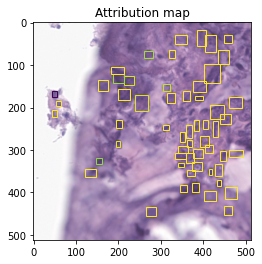

Attribution: -3.74%, Label: Epithelial
Attribution: 1.74%, Label: Connective
Attribution: 1.67%, Label: Epithelial
Attribution: 1.67%, Label: Epithelial
Attribution: 1.67%, Label: Epithelial
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 54
Relative contribution per cell: 1.48%
Class Lymphocyte
Number of cells: 1
Relative contribution per cell: 1.54%
Class Plasma
Number of cells: 2
Relative contribution per cell: 1.40%
Class Eosinohil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Connective
Number of cells: 10
Relative contribution per cell: 1.60%


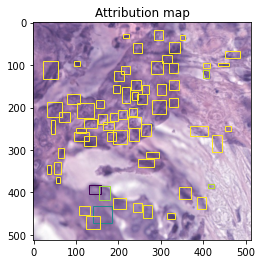

Attribution: -7.96%, Label: Lymphocyte
Attribution: -3.67%, Label: Plasma
Attribution: -3.35%, Label: Connective
Attribution: -3.29%, Label: Connective
Attribution: -3.19%, Label: Plasma
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 11
Relative contribution per cell: 0.34%
Class Lymphocyte
Number of cells: 4
Relative contribution per cell: -11.22%
Class Plasma
Number of cells: 3
Relative contribution per cell: -7.14%
Class Eosinohil
Number of cells: 2
Relative contribution per cell: -8.62%
Class Connective
Number of cells: 39
Relative contribution per cell: -0.33%


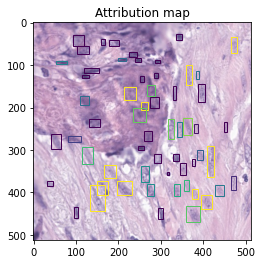

Attribution: -7.18%, Label: Connective
Attribution: -4.88%, Label: Lymphocyte
Attribution: -4.36%, Label: Lymphocyte
Attribution: -4.13%, Label: Plasma
Attribution: -4.02%, Label: Lymphocyte
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 12
Relative contribution per cell: -1.92%
Class Lymphocyte
Number of cells: 6
Relative contribution per cell: -6.96%
Class Plasma
Number of cells: 3
Relative contribution per cell: -6.34%
Class Eosinohil
Number of cells: 1
Relative contribution per cell: -6.05%
Class Connective
Number of cells: 29
Relative contribution per cell: 0.35%


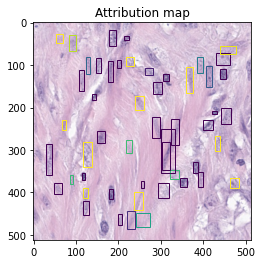

Attribution: -2.20%, Label: Epithelial
Attribution: 1.25%, Label: Epithelial
Attribution: 1.21%, Label: Epithelial
Attribution: 1.15%, Label: Connective
Attribution: 1.14%, Label: Connective
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 88
Relative contribution per cell: 0.99%
Class Lymphocyte
Number of cells: 1
Relative contribution per cell: 0.97%
Class Plasma
Number of cells: 3
Relative contribution per cell: 0.98%
Class Eosinohil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Connective
Number of cells: 8
Relative contribution per cell: 1.08%


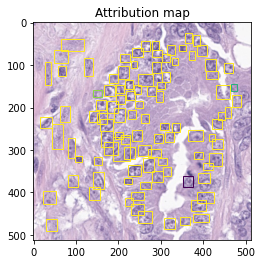

Attribution: -2.81%, Label: Epithelial
Attribution: 1.72%, Label: Epithelial
Attribution: 0.98%, Label: Epithelial
Attribution: 0.97%, Label: Epithelial
Attribution: 0.95%, Label: Epithelial
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 116
Relative contribution per cell: 0.85%
Class Lymphocyte
Number of cells: 0
Relative contribution per cell: 0.00%
Class Plasma
Number of cells: 2
Relative contribution per cell: 0.71%
Class Eosinohil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Connective
Number of cells: 0
Relative contribution per cell: 0.00%


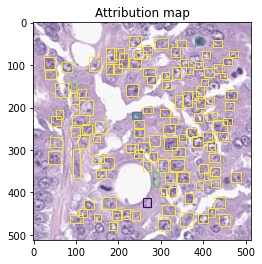

Attribution: -2.32%, Label: Epithelial
Attribution: 1.44%, Label: Epithelial
Attribution: 1.23%, Label: Epithelial
Attribution: 1.20%, Label: Epithelial
Attribution: 1.19%, Label: Connective
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 72
Relative contribution per cell: 1.05%
Class Lymphocyte
Number of cells: 6
Relative contribution per cell: 1.11%
Class Plasma
Number of cells: 1
Relative contribution per cell: 1.04%
Class Eosinohil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Connective
Number of cells: 15
Relative contribution per cell: 1.12%


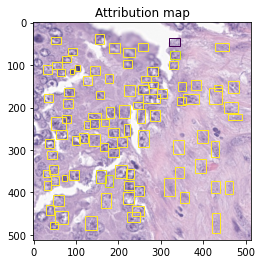

Attribution: -5.94%, Label: Connective
Attribution: -3.70%, Label: Lymphocyte
Attribution: -3.66%, Label: Lymphocyte
Attribution: -3.58%, Label: Lymphocyte
Attribution: -3.39%, Label: Lymphocyte
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 21
Relative contribution per cell: -0.31%
Class Lymphocyte
Number of cells: 15
Relative contribution per cell: -5.15%
Class Plasma
Number of cells: 2
Relative contribution per cell: -4.27%
Class Eosinohil
Number of cells: 2
Relative contribution per cell: -2.73%
Class Connective
Number of cells: 25
Relative contribution per cell: 0.09%


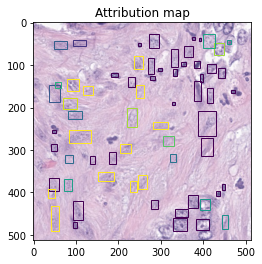

Attribution: -8.10%, Label: Lymphocyte
Attribution: 3.05%, Label: Connective
Attribution: 2.57%, Label: Epithelial
Attribution: 2.56%, Label: Connective
Attribution: 2.53%, Label: Connective
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 18
Relative contribution per cell: 1.15%
Class Lymphocyte
Number of cells: 15
Relative contribution per cell: -1.70%
Class Plasma
Number of cells: 3
Relative contribution per cell: 0.53%
Class Eosinohil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Connective
Number of cells: 28
Relative contribution per cell: 1.87%


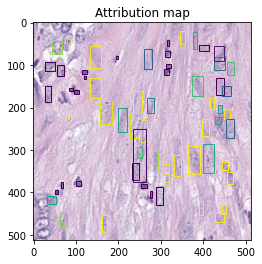

Attribution: -5.92%, Label: Connective
Attribution: 2.28%, Label: Epithelial
Attribution: 2.17%, Label: Epithelial
Attribution: 2.01%, Label: Epithelial
Attribution: 2.00%, Label: Epithelial
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 47
Relative contribution per cell: 1.72%
Class Lymphocyte
Number of cells: 1
Relative contribution per cell: 0.26%
Class Plasma
Number of cells: 2
Relative contribution per cell: 1.22%
Class Eosinohil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Connective
Number of cells: 15
Relative contribution per cell: 1.10%


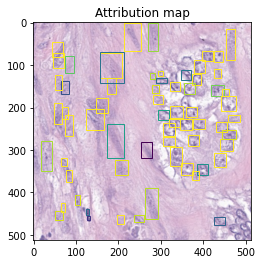

In [106]:
def tensor_image_to_numpy(image):
    # Converts (C, H, W) f32 to (H, W, C) u8
    return np.array(image.cpu().permute(1, 2, 0) * 255, dtype=np.uint8)

# print(len(attributions[0]))

for quadrant_idx in range(10):
    CLASSES = ["Neutrophil", "Epithelial", "Lymphocyte", "Plasma", "Eosinohil", "Connective"]

    idx = in_quadrant[quadrant_idx]
    ix = slide.spot_locations.image_x[idx]
    iy = slide.spot_locations.image_y[idx]
    img = slide.image[:, iy - 256:iy + 256, ix - 256:ix + 256]

    render_attributions(tensor_image_to_numpy(img), inferences[idx], *attributions[quadrant_idx], slide.genes.index("EPCAM"))
    
"""
Global attention pooling
We have cell type counts, can predict characteristic expression (or vice veras)

sum[proportions dot characteristic expression] * n = total expression
can try to find cells that dont match canonical lineages
quadratic programming (look at DNA methylation papers)
"""
pass

### Results for AXIN2

AXIN2 is involved in regulating cell apoptosis

Attribution: -5.72%, Label: Plasma
Attribution: 3.98%, Label: Connective
Attribution: 3.85%, Label: Epithelial
Attribution: 3.84%, Label: Epithelial
Attribution: 3.55%, Label: Epithelial
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 46
Relative contribution per cell: 1.56%
Class Lymphocyte
Number of cells: 5
Relative contribution per cell: 2.53%
Class Plasma
Number of cells: 1
Relative contribution per cell: -5.72%
Class Eosinohil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Connective
Number of cells: 4
Relative contribution per cell: 2.50%


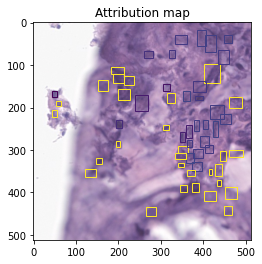

Attribution: -6.05%, Label: Epithelial
Attribution: 3.64%, Label: Connective
Attribution: 3.49%, Label: Epithelial
Attribution: 3.07%, Label: Connective
Attribution: 2.98%, Label: Epithelial
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 54
Relative contribution per cell: 1.32%
Class Lymphocyte
Number of cells: 1
Relative contribution per cell: 2.93%
Class Plasma
Number of cells: 2
Relative contribution per cell: 2.05%
Class Eosinohil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Connective
Number of cells: 10
Relative contribution per cell: 2.16%


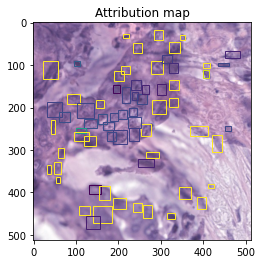

Attribution: -6.94%, Label: Lymphocyte
Attribution: -4.47%, Label: Plasma
Attribution: -4.23%, Label: Connective
Attribution: -4.04%, Label: Plasma
Attribution: -3.80%, Label: Connective
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 11
Relative contribution per cell: -1.56%
Class Lymphocyte
Number of cells: 4
Relative contribution per cell: -3.80%
Class Plasma
Number of cells: 3
Relative contribution per cell: -2.83%
Class Eosinohil
Number of cells: 2
Relative contribution per cell: -3.10%
Class Connective
Number of cells: 39
Relative contribution per cell: -1.36%


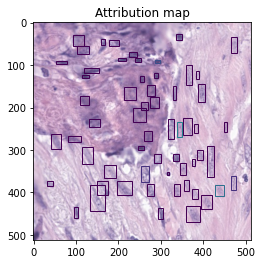

Attribution: -7.34%, Label: Connective
Attribution: -4.69%, Label: Lymphocyte
Attribution: -4.65%, Label: Plasma
Attribution: -4.60%, Label: Eosinohil
Attribution: -4.08%, Label: Epithelial
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 12
Relative contribution per cell: -2.30%
Class Lymphocyte
Number of cells: 6
Relative contribution per cell: -3.70%
Class Plasma
Number of cells: 3
Relative contribution per cell: -4.25%
Class Eosinohil
Number of cells: 1
Relative contribution per cell: -4.89%
Class Connective
Number of cells: 29
Relative contribution per cell: -1.12%


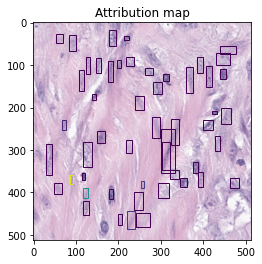

Attribution: -4.98%, Label: Epithelial
Attribution: 2.60%, Label: Epithelial
Attribution: 2.36%, Label: Epithelial
Attribution: 2.31%, Label: Epithelial
Attribution: 2.18%, Label: Epithelial
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 88
Relative contribution per cell: 0.89%
Class Lymphocyte
Number of cells: 1
Relative contribution per cell: 2.02%
Class Plasma
Number of cells: 3
Relative contribution per cell: 2.20%
Class Eosinohil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Connective
Number of cells: 8
Relative contribution per cell: 1.61%


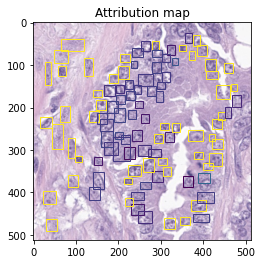

Attribution: -4.02%, Label: Epithelial
Attribution: -2.01%, Label: Epithelial
Attribution: 1.97%, Label: Epithelial
Attribution: 1.97%, Label: Epithelial
Attribution: 1.93%, Label: Epithelial
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 116
Relative contribution per cell: 0.83%
Class Lymphocyte
Number of cells: 0
Relative contribution per cell: 0.00%
Class Plasma
Number of cells: 2
Relative contribution per cell: 1.61%
Class Eosinohil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Connective
Number of cells: 0
Relative contribution per cell: 0.00%


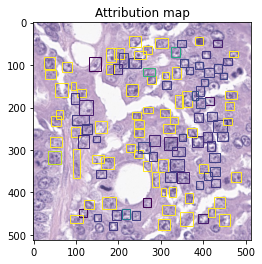

Attribution: -5.04%, Label: Epithelial
Attribution: 2.61%, Label: Epithelial
Attribution: 2.45%, Label: Epithelial
Attribution: 2.37%, Label: Epithelial
Attribution: 2.32%, Label: Epithelial
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 72
Relative contribution per cell: 0.96%
Class Lymphocyte
Number of cells: 6
Relative contribution per cell: 1.72%
Class Plasma
Number of cells: 1
Relative contribution per cell: 1.79%
Class Eosinohil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Connective
Number of cells: 15
Relative contribution per cell: 1.26%


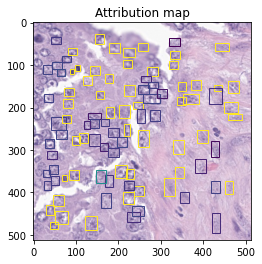

Attribution: -5.10%, Label: Lymphocyte
Attribution: -4.48%, Label: Connective
Attribution: -4.46%, Label: Connective
Attribution: -4.02%, Label: Lymphocyte
Attribution: -3.46%, Label: Eosinohil
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 21
Relative contribution per cell: -1.13%
Class Lymphocyte
Number of cells: 15
Relative contribution per cell: -2.69%
Class Plasma
Number of cells: 2
Relative contribution per cell: -1.37%
Class Eosinohil
Number of cells: 2
Relative contribution per cell: -2.12%
Class Connective
Number of cells: 25
Relative contribution per cell: -1.16%


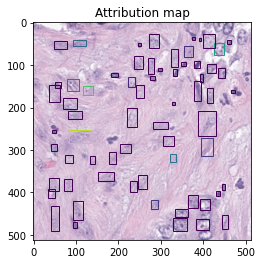

Attribution: -17.17%, Label: Lymphocyte
Attribution: 4.14%, Label: Connective
Attribution: 3.56%, Label: Lymphocyte
Attribution: 3.50%, Label: Epithelial
Attribution: 3.18%, Label: Lymphocyte
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 18
Relative contribution per cell: 2.08%
Class Lymphocyte
Number of cells: 15
Relative contribution per cell: 0.82%
Class Plasma
Number of cells: 3
Relative contribution per cell: 3.76%
Class Eosinohil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Connective
Number of cells: 28
Relative contribution per cell: 1.39%


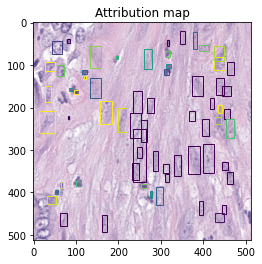

Attribution: -11.45%, Label: Epithelial
Attribution: 3.83%, Label: Epithelial
Attribution: 3.36%, Label: Epithelial
Attribution: 3.29%, Label: Epithelial
Attribution: 3.23%, Label: Epithelial
Class Neutrophil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Epithelial
Number of cells: 47
Relative contribution per cell: 1.48%
Class Lymphocyte
Number of cells: 1
Relative contribution per cell: 3.11%
Class Plasma
Number of cells: 2
Relative contribution per cell: 3.82%
Class Eosinohil
Number of cells: 0
Relative contribution per cell: 0.00%
Class Connective
Number of cells: 15
Relative contribution per cell: 1.30%


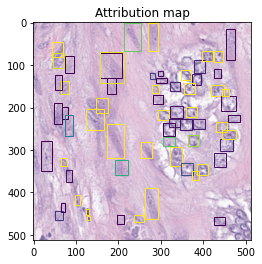

In [145]:
def tensor_image_to_numpy(image):
    # Converts (C, H, W) f32 to (H, W, C) u8
    return np.array(image.cpu().permute(1, 2, 0) * 255, dtype=np.uint8)

# print(len(attributions[0]))

for quadrant_idx in range(10):
    CLASSES = ["Neutrophil", "Epithelial", "Lymphocyte", "Plasma", "Eosinohil", "Connective"]

    idx = in_quadrant[quadrant_idx]
    ix = slide.spot_locations.image_x[idx]
    iy = slide.spot_locations.image_y[idx]
    img = slide.image[:, iy - 256:iy + 256, ix - 256:ix + 256]

    render_attributions(tensor_image_to_numpy(img), inferences[idx], *attributions[quadrant_idx], slide.genes.index("AXIN2"))

In [61]:
print(*slide.genes,sep='\n')

DES
IGKC
COL1A2
ACTG2
TPM2
COL3A1
ACTA2
COL1A1
TAGLN
MYL9
IGHA1
FLNA
MYLK
SYNM
SPARC
JCHAIN
EPCAM
S100A6
FN1
KRT8
HSPB6
CNN1
CEACAM5
SYNPO2
LCN2
TSPAN8
IGHG1
DCN
FABP1
TPM1
OLFM4
IGFBP7
TFF3
FXYD3
CCN2
TNC
LUM
AEBP1
GPX2
LGALS4
PIGR
SPINT2
GREM1
PGM3
SPINK1
CLDN4
TNFSF10
MYL12B
S100A10
PLCB4
PHGR1
MMP7
CCN1
SULF1
ZMYND8
CXCL14
C3
SFRP4
ACTB
ERF
MMP2
CLDN3
C1R
HMGCS2
POSTN
EPHB2
BGN
MSL1
FSTL1
ELF3
MAL2
S100A14
SCD
RAB25
LAD1
HIST1H1B
EXT1
DPEP1
LYZ
CALD1
MUC12
HMGA1
MT2A
MIF
KLK10
CEACAM1
CLU
COL6A3
PPP1R1B
C19orf33
SPP1
CDH1
GM2A
ATP1B1
CSTB
IFT20
SLC12A2
THBS1
AXIN2
SERPINF1
CCDC80
ACSL5
ESRP1
LGR5
GPRC5A
CDH17
LGALS3
DTX3L
HEXA
VIM
NOX1
FBN1
FABP5
LSR
TNS1
COL6A2
PTGDS
GPX4
FBLN1
EXT2
FAM3D
CLDN7
SNHG32
MICAL2
TRIP12
CDX1
REEP3
COL12A1
KLC4
KRT20
MUC13
POF1B
PRR15L
BTBD7
S100P
THBS2
MYC
SLC38A10
RNF43
COL5A1
CAVIN1
FOSB
ANXA1
TFG
TPD52
GGH
PDZK1IP1
RARRES2
HIST1H3H
CAPZA2
C1S
CTHRC1
TSPAN1
EGR1
ARID4A
ABCF1
KLK6
MPHOSPH10
INSIG1
TIMP1
STARD10
TAOK2
MYH14
TMEM238
PLA2G2A
HSPB1
ST14
T